# Dataset

The dataset includes 5000 movies details scraped from IMDB website. The information of movies in dataset will be used to train model to predict the successful of a new movie before its release. Included factors are:

- director_name: Name of the director
- Budget of the movie
- Genre of the movie
- Original language the movie is in
- Casts in the movie and many more...

In [45]:
import plotly.graph_objects as go
import chart_studio.plotly as py
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

init_notebook_mode(connected=True)
cf.go_offline(connected=True)
cf.set_config_file(theme="pearl")
#pd.set_option('display.max_columns', 30)
%matplotlib inline

In [46]:
import itertools
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter

In [47]:
data = pd.read_csv("movie_metadata.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

# Cleaning
## Remove duplicates

In [48]:
data.drop_duplicates(keep='first', inplace = True)

## Examine genre column

This column contains genres of movie. A movie can be tagged with different genres, therefore, we need to process the data in this column first.

In [49]:
data["genres"].head()

0    Action|Adventure|Fantasy|Sci-Fi
1           Action|Adventure|Fantasy
2          Action|Adventure|Thriller
3                    Action|Thriller
4                        Documentary
Name: genres, dtype: object

In [50]:
genres = list(itertools.chain(*data.genres.apply(lambda x: x.split("|"))))
print(f'there are {len(set(genres))} genres in the dataset which are: {set(genres)}')

there are 26 genres in the dataset which are: {'Musical', 'Horror', 'Mystery', 'Western', 'Music', 'Short', 'Crime', 'Reality-TV', 'Romance', 'Thriller', 'Adventure', 'Biography', 'Drama', 'News', 'Action', 'Family', 'Film-Noir', 'History', 'Comedy', 'Animation', 'War', 'Sci-Fi', 'Sport', 'Game-Show', 'Fantasy', 'Documentary'}


There are some duplicate in genre such as "Music" and "Musical" need to be remove. Besides, "Reality-TV", "Game-Show" and "News" will also be removed since they are not a movie genre.

In [51]:
data.genres = data.genres.str.replace("Musical", "Music")
genres = list(itertools.chain(*data.genres.apply(lambda x: x.split("|"))))
genres = [genre for genre in genres if genre not in ["Reality-TV","Game-Show","News"]]
print(len(set(genres)))

22


We now have 22 genres. Let's plot mean IMDB score of each genre.

In [52]:
d = {}
for genre in set(genres):
    score = [imdb for genre_list, imdb in zip(data.genres.apply(lambda x: x.split("|")), data["imdb_score"]) if genre in genre_list]
    d[genre] = np.sum(score)

In [53]:
genres_mean = {}    
for genre in d.keys():    
    genres_mean[genre] = d[genre]/Counter(genres)[genre]

In [54]:
df = pd.DataFrame(
    [{"genre": genre, "mean IMDB": imbd} for genre, imbd in genres_mean.items()])
df.iplot(kind='bar', x="genre", y="mean IMDB")

There is not much difference between genres. Almost all the mean are in range of 6 - 8. Therefore, the genres column can be removed from the dataframe as it does not relate to the IMDB score

In [55]:
data.drop(["genres"], axis = 1, inplace=True)

## Missing value

As in above table, the number of value count for each column are not the same, which indicates that there are several rows those are missing some of value we have to handle.

In [56]:
data.isnull().sum(axis = 0).sort_values(ascending=False)

gross                        874
budget                       487
aspect_ratio                 327
content_rating               301
plot_keywords                152
title_year                   107
director_name                103
director_facebook_likes      103
num_critic_for_reviews        49
actor_3_name                  23
actor_3_facebook_likes        23
num_user_for_reviews          21
color                         19
duration                      15
facenumber_in_poster          13
actor_2_name                  13
actor_2_facebook_likes        13
language                      12
actor_1_name                   7
actor_1_facebook_likes         7
country                        5
cast_total_facebook_likes      0
num_voted_users                0
movie_title                    0
movie_imdb_link                0
imdb_score                     0
movie_facebook_likes           0
dtype: int64

<AxesSubplot:>

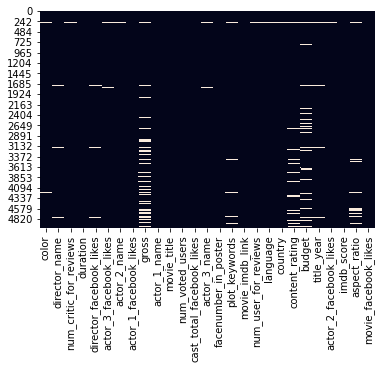

In [57]:
sns.heatmap(data.isnull(), cbar=False)

As we can see, "budget" and "gross" are columns with the most number of missing value. However, we can't either remove these two columns due the logically relation with the IMDB score or replace the missing values with mean of column. Therefore, the best solution is to remove rows with missing value.

In [58]:
data.dropna(subset = ["budget", "gross"], inplace=True)
print(len(data))

3857


The dataset has 3857 entries which is 77% of initial dataset. Let's take a look at other columns with missing values.

Before trying to impute the missing values, we want to measure how important three variables: aspect_ratio, content_rating, and plot_keywords which have the most missing value in the current dataset.

In [59]:
data["aspect_ratio"].value_counts()

2.35     1995
1.85     1600
1.37       50
1.78       41
1.66       40
1.33       19
2.39       11
2.20       10
2.40        3
2.76        3
2.00        3
1.75        2
2.24        1
1.18        1
2.55        1
1.77        1
16.00       1
1.50        1
Name: aspect_ratio, dtype: int64

the most common ratio are 2.35 and 1.85. To measure the importance of this variable, we will divide this variable into 3 groups:

- group 1 is 2.35
- group 2 is 1.85
- group 0 is other ratio

First we will replace missing value with 0 and then we will calculate the mean of IMDB score for each group.

In [60]:
#create a copy dataframe with only "aspect_ratio" and "imdb_score" for evaluation
temp_data = data[["aspect_ratio", "imdb_score"]].copy()

#fill n/a value
temp_data.fillna(0, inplace=True)

#catergorizing values into 3 groups and calculate mean of each group
temp_data["aspect_ratio"] = temp_data["aspect_ratio"].apply(lambda x: 1 if x==2.35 else 2 if x==1.85 else 0)
temp_data.groupby("aspect_ratio").mean()

,imdb_score
aspect_ratio,
0,6.672519
1,6.508471
2,6.373938


There is no significant different between these groups, therefore removing this variable won't affect the further analyzes

In [61]:
data.drop(["aspect_ratio"], axis = 1, inplace =True)

We further remove "plot_keywords" columns as it is considered as not related to the IMDB score analyze due to its diveristy.

In [62]:
data["plot_keywords"].nunique()

3759

In [63]:
data.drop(["plot_keywords"], axis = 1, inplace=True)

The last column with many missing values is "content_rating". We will examize its data

In [64]:
data["content_rating"].unique()

array(['PG-13', 'PG', 'G', 'R', 'Approved', 'NC-17', nan, 'X',
       'Not Rated', 'Unrated', 'M', 'GP', 'Passed'], dtype=object)

According to the rating system nowadays, it includes 5 ratings: PG-13, PG, NC-17, G, R. Therefore, we need to replace some old ratings with the new ones as following:

- M = GP = PG
- X = NC-17
- other ungrouped ratings such as: “Approved”, “Not Rated”, “Passed”, “Unrated” will be grouped as R

There is no suitable replacement for missing value for this column, therefore these rows will be remove from the dataset

In [65]:
#Remove rows with missing values
data.dropna(subset = ["content_rating"], inplace=True)

In [66]:
data["content_rating"].replace({"M":"PG","GP":"PG", "X":"NC-17", "Approved":"R","Not Rated":"R","Passed":"R", "Unrated":"R"}, inplace=True)
data["content_rating"].unique()

array(['PG-13', 'PG', 'G', 'R', 'NC-17'], dtype=object)

## Removing unrelated columns

**Is "Color" relates to the IMDB score?**

In [67]:
data.color.value_counts()

Color               3680
 Black and White     124
Name: color, dtype: int64

96% of this column is color which indicates that this variable is nearly constant. Therefore, removing it will not affect the analyzing result.

In [68]:
data.drop(["color"], axis = 1, inplace=True)

Other columns with diverse values those are not useful for IDMB classification such as: "movie_title", "director_name", "actor_1_name", "actor_2_name", "actor_3_name" and "movie_imdb_link" will be removed from the dataset.

In [69]:
print(f'number of unique director name: {data["director_name"].nunique()}')
print(f'number of unique actor 1 name: {data["actor_1_name"].nunique()}')
print(f'number of unique actor 2 name: {data["actor_2_name"].nunique()}')
print(f'number of unique actor 3 name: {data["actor_3_name"].nunique()}')

number of unique director name: 1709
number of unique actor 1 name: 1473
number of unique actor 2 name: 2246
number of unique actor 3 name: 2646


In [70]:
data.drop(["movie_title","director_name", "actor_1_name", "actor_2_name", "actor_3_name", "movie_imdb_link"], axis = 1, inplace=True)

**How about "language" and "country"? Are they relevant in predicting IMDB?**

In [71]:
lang_count = data.language.value_counts()
lang_count_pct = lang_count*100/len(data)
fig = px.pie(lang_count_pct, values=lang_count_pct.values, names=lang_count_pct.index, title="Proportion for movie language")
fig.update_traces(hoverinfo='label+percent+value',textinfo='none')
fig.show()

95% of movie are in English, therefore, this variable is nearly constant. Let's remove it.

In [72]:
data.drop(["language"], axis = 1, inplace=True)

In [73]:
country_count = data.country.value_counts()
country_count_pct = country_count*100/len(data)
fig = px.pie(country_count_pct, values=country_count_pct.values, names=country_count_pct.index, title="Proportion for country")
fig.update_traces(hoverinfo='label+percent+value',textinfo='none')
fig.show()

Majority of movies come from USA (79%) and UK (8%), the rest 13% comes from other countries. Therefore, we will group other countries together to make this columns have few categories.

In [74]:
data.country = data.country.apply(lambda x: "Other" if x not in ["USA", "UK"] else x)

The rest missing values is insignificant in comparison to the dataset, therefore, these rows will be dropped.

In [75]:
data.isnull().sum(axis = 0).sort_values(ascending=False)

facenumber_in_poster         6
actor_3_facebook_likes       6
actor_2_facebook_likes       2
actor_1_facebook_likes       1
num_critic_for_reviews       1
content_rating               0
country                      0
num_user_for_reviews         0
imdb_score                   0
cast_total_facebook_likes    0
num_voted_users              0
gross                        0
budget                       0
title_year                   0
director_facebook_likes      0
duration                     0
movie_facebook_likes         0
dtype: int64

In [76]:
data.dropna(inplace=True)

Furthermore, the title_year is not really related to the IMDB score, therefore, this column will be dropped

In [77]:
data.drop("title_year", axis=1, inplace=True)

## Correlation check

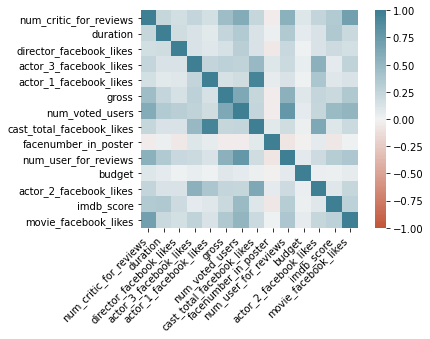

In [78]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Based on the heatmap, "actor_1_facebook_like", "actor_2_facebook_like" and "actor_3_facebook_like" are highly correlated with the "cast_total_facebook_likes". Therefore, we will remove these columns and only keep "cast_total_facebook_likes".

In [79]:
data.drop(["actor_1_facebook_likes", "actor_2_facebook_likes", "actor_3_facebook_likes"], axis=1, inplace=True)

There are also high correlation between "num_critic_for_reviews" and "num_user_for_reviews". We will take the ratio of these variable and remove them.

In [80]:
data["review_ratio"] = data["num_critic_for_reviews"] / data["num_user_for_reviews"]
data.drop(["num_critic_for_reviews","num_user_for_reviews"], axis=1, inplace=True)

The correlation heatmap now is:

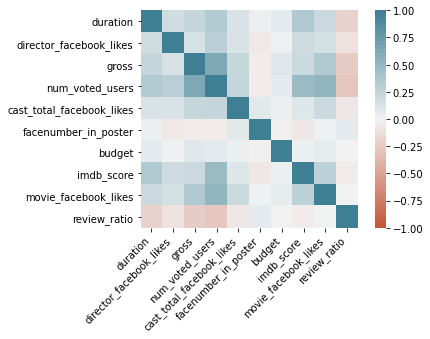

In [81]:
corr = data.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

It looks better and there is no high correlation between variables now. We now can separate the dataframe into features and target.

In [82]:
target = data["imdb_score"]
target.shape

(3793,)

In [83]:
features = data.drop("imdb_score", axis=1)
features.shape

(3793, 11)

# Preprocessing

There are several categorical features in the dataset, therefore, it is necessary to encode those features before fitting into a machine learning model.

## Encoding

Two categorical features: country and content_rating will be encoded using OneHotEncoder before fitting to any model.

In [84]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(drop='first'), [6,7])], remainder='passthrough')
X = np.array(columnTransformer.fit_transform(features))

In [209]:
col = np.array([1,2,3,4,5,6,"duration", "director_facebook_likes", "gross", "num_voted_users", "cast_total_facebook_likes", "facenumber_in_poster", "budget", "movie_facebook_likes","review_ratio"])

Instead of having 11 features, we now have 15 features.

## Scaling

Besides, the data is mostly skewed and have outliers, RobustScaler will be used when scaling the data.

In [85]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(3793, 15)

## Splitting into training, and testing set

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, train_size=0.8, random_state=5)

print(f'Train set shape: {X_train.shape}, {y_train.shape}')
print(f'Test set shape: {X_test.shape}, {y_test.shape}')

Train set shape: (3034, 15), (3034,)
Test set shape: (759, 15), (759,)


# Model implementation

## Linear Regression

In [232]:
from sklearn.linear_model import LinearRegression, RANSACRegressor, SGDRegressor
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
sgd = SGDRegressor()
ransac = RANSACRegressor()


lr.fit(X_train, y_train)
print(f"score on training set for Linear Regression: {lr.score(X_train, y_train):.2f}")
lr_pred = lr.predict(X_test)
print(f"mean squared error of Linear Regression: {mean_squared_error(y_test, lr_pred):.2f}\n")

sgd.fit(X_train, y_train)
print(f"score on training set for SGD: {sgd.score(X_train, y_train):.2f}")
sgd_pred = sgd.predict(X_test)
print(f"mean squared error of SGD: {mean_squared_error(y_test, sgd_pred):.2f}\n")

ransac.fit(X_train, y_train)
print(f"score on training set for RANSAC Regression: {ransac.score(X_train, y_train):.2f}")
ransac_pred = ransac.predict(X_test)
print(f"mean squared error of RANSAC Regression: {mean_squared_error(y_test, ransac_pred):.2f}\n")

score on training set for Linear Regression: 0.35
mean squared error of Linear Regression: 0.80

score on training set for SGD: -75945193192403386368.00
mean squared error of SGD: 204639914594434252800.00

score on training set for RANSAC Regression: -0.42
mean squared error of RANSAC Regression: 6.34



The scores of all models look bad. Especially for SGD and RANSAC, they cannot learn anything from the training set.

## Linear Regression with polynomial feature

In [234]:
from sklearn.preprocessing import PolynomialFeatures

poly =PolynomialFeatures(degree=2, interaction_only=True)
X_poly = poly.fit_transform(X_scaled)
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, target, train_size=0.8, random_state=5)

lr = LinearRegression()
sgd = SGDRegressor()
ransac = RANSACRegressor()

lr.fit(X_poly_train, y_poly_train)
print(f"score on training set for Linear Regression: {lr.score(X_poly_train, y_poly_train):.2f}")
lr_pred = lr.predict(X_poly_test)
print(f"mean squared error of Linear Regression: {mean_squared_error(y_poly_test, lr_pred):.2f}\n")

sgd.fit(X_poly_train, y_poly_train)
print(f"score on training set for SGD: {sgd.score(X_poly_train, y_poly_train):.2f}")
sgd_pred = sgd.predict(X_poly_test)
print(f"mean squared error of SGD: {mean_squared_error(y_poly_test, sgd_pred):.2f}\n")

ransac.fit(X_poly_train, y_poly_train)
print(f"score on training set for RANSAC Regression: {ransac.score(X_poly_train, y_poly_train):.2f}")
ransac_pred = ransac.predict(X_poly_test)
print(f"mean squared error of RANSAC Regression: {mean_squared_error(y_poly_test, ransac_pred):.2f}\n")

score on training set for Linear Regression: 0.48
mean squared error of Linear Regression: 0.92

score on training set for SGD: -4326021982866397098009427968.00
mean squared error of SGD: 10393474309833757036793298944.00

score on training set for RANSAC Regression: -75.44
mean squared error of RANSAC Regression: 181.08



When transforming the features to polynomial with degree of 2, the overall score is still the same as before.

## SVM

In [166]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)
print(f"score on training set for SVR: {svr.score(X_train, y_train):.2f}")
svr_pred = svr.predict(X_test)
print(f"mean squared error of SVR: {mean_squared_error(y_test, svr_pred):.2f}\n")

score on training set for SVR: 0.44
mean squared error of SVR: 0.69



SVR generalize lower mean squared error than previous models.

In [167]:
svr = SVR()
svr.fit(X_poly_train, y_poly_train)
print(f"score on training set for SVR: {svr.score(X_poly_train, y_poly_train):.2f}")
svr_pred = svr.predict(X_poly_test)
print(f"mean squared error of SVR: {mean_squared_error(y_poly_test, svr_pred):.2f}\n")

score on training set for SVR: 0.28
mean squared error of SVR: 0.88



There is no improvement when fitting polynomial features to the svr model.

## Decision Tree Regression

In [169]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=5)
dt.fit(X_train, y_train)
print(f"score on training set for Decision Tree: {dt.score(X_train, y_train):.2f}")
dt_pred = dt.predict(X_test)
print(f"mean squared error of Linear Regression: {mean_squared_error(y_test, dt_pred):.2f}\n")

score on training set for Decision Tree: 1.00
mean squared error of Linear Regression: 1.00



We can see that the decision tree model is overfiting, despite of perfect score on training set, the generalization ability is not better than previous models. We will try to prune the tree a little bit to increase it generalization ability.

In [173]:
dt = DecisionTreeRegressor(random_state=5, max_depth=5)
dt.fit(X_train, y_train)
print(f"score on training set for Decision Tree: {dt.score(X_train, y_train):.2f}")
dt_pred = dt.predict(X_test)
print(f"mean squared error of Linear Regression: {mean_squared_error(y_test, dt_pred):.2f}\n")

score on training set for Decision Tree: 0.48
mean squared error of Linear Regression: 0.77



After briefly fitting the data into different models, we can see that the overall score and mean squared error are not good. We will try to apply some feature selection and tuning to try improving the performance.

# Feature selection and tuning
## Feature selection
Mutual information will be used as a criteria for evaluating the importance of features.

In [175]:
mi=feature_selection.mutual_info_regression(X_scaled,target)
mi

array([0.0095051 , 0.00615775, 0.        , 0.        , 0.00373491,
       0.00259252, 0.10955473, 0.07335594, 0.09021356, 0.23264283,
       0.06550451, 0.00239903, 0.03489395, 0.12609593, 0.05432844])

As expected, not all the feature are important in term of their mutual information. 0.05 will be chosen as the threshold to select feature.

In [210]:
print(f'Number of selected feature: {len(np.where(mi>=0.05)[0])}')
print(f'Name of selected feature: {col[np.where(mi>=0.05)[0]]}')

Number of selected feature: 7
Name of selected feature: ['duration' 'director_facebook_likes' 'gross' 'num_voted_users'
 'cast_total_facebook_likes' 'movie_facebook_likes' 'review_ratio']


In [228]:
X_selected = X_scaled[:, np.where(mi>=0.05)[0]]

## Tuning
### Linear Regression

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, target, train_size=0.8, random_state=5)

lr = LinearRegression()
sgd = SGDRegressor()
ransac = RANSACRegressor()


lr.fit(X_train, y_train)
print(f"score on training set for Linear Regression: {lr.score(X_train, y_train):.2f}")
lr_pred = lr.predict(X_test)
print(f"mean squared error of Linear Regression: {mean_squared_error(y_test, lr_pred):.2f}\n")

sgd.fit(X_train, y_train)
print(f"score on training set for SGD: {sgd.score(X_train, y_train):.2f}")
sgd_pred = sgd.predict(X_test)
print(f"mean squared error of SGD: {mean_squared_error(y_test, sgd_pred):.2f}\n")

ransac.fit(X_train, y_train)
print(f"score on training set for RANSAC Regression: {ransac.score(X_train, y_train):.2f}")
ransac_pred = ransac.predict(X_test)
print(f"mean squared error of RANSAC Regression: {mean_squared_error(y_test, ransac_pred):.2f}\n")

score on training set for Linear Regression: 0.31
mean squared error of Linear Regression: 0.83

score on training set for SGD: -5829272543467453440.00
mean squared error of SGD: 6538189577710843904.00

score on training set for RANSAC Regression: -2.06
mean squared error of RANSAC Regression: 3.73



The overall score is still as bad as before, therefore, we will skip tuning parameter for these linear models.
### SVM

In [236]:
svr = SVR()
svr.fit(X_train, y_train)
print(f"score on training set for SVR: {svr.score(X_train, y_train):.2f}")
svr_pred = svr.predict(X_test)
print(f"mean squared error of SVR: {mean_squared_error(y_test, svr_pred):.2f}\n")

score on training set for SVR: 0.36
mean squared error of SVR: 0.77



The result is improved a little bit on the new dataset without tuning. We can try tuning the hyper parameter to see if the result is improved further or not.

In [239]:
from sklearn.model_selection import GridSearchCV
svr = SVR(kernel="rbf")

param = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(svr, param_grid=param, cv=5, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}\n")
print(f"Best cross-validation score: {grid.best_score_:.2f}\n")

y_pred = grid.predict(X_test)
print(f"mean squared error: {mean_squared_error(y_test, y_pred):.2f}")

Best params:
{'C': 1, 'gamma': 0.1}

Best cross-validation score: 0.39

accuracy score: 0.73


With the best parameter, we only improve score and mean squared a little bit.
### Decision Tree Regression

In [241]:
dt = DecisionTreeRegressor(random_state=5)

param = {'max_depth': [i for i in range(1,10)],
        'max_features': [i for i in range(1,X_train.shape[1])]}

grid = GridSearchCV(dt, param_grid=param, cv=5, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}\n")
print(f"Best cross-validation score: {grid.best_score_:.2f}\n")

y_pred = grid.predict(X_test)
print(f"mean squared error: {mean_squared_error(y_test, y_pred):.2f}")

Best params:
{'max_depth': 5, 'max_features': 6}

Best cross-validation score: 0.36

mean squared error: 0.77


In [242]:
def plot_feature_importance(model,x,name):
    n_feature=x.shape[1]
    print(n_feature)
    plt.barh(range(n_feature),model.feature_importances_)
    plt.yticks(np.arange(n_feature),name)
    plt.xlabel("Feature importance")
    plt.ylabel("feature")

In [247]:
dt = DecisionTreeRegressor(max_depth=5, max_features=6, random_state=5)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, max_features=6, random_state=5)

7


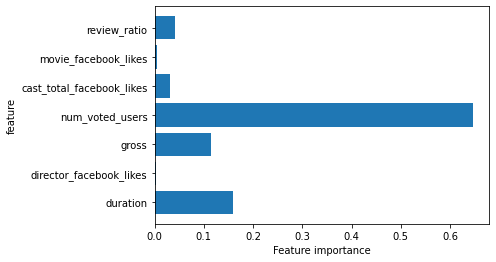

In [248]:
plot_feature_importance(dt,X_train,col[np.where(mi>=0.05)[0]])

In comparison to the previous decision tree, there is no improvement with this model. Despite of new selected features, the decision tree only use 5 features and the most important one is num_voted_users.
# Ensemble learning
## Voting Regressor
For voting regressor, previous linear models will be used as weak learner.

In [253]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
svr = SVR(kernel="rbf", C=1, gamma=0.1)
dt = DecisionTreeRegressor(max_depth=5, max_features=6)

In [255]:
voting_rg = VotingRegressor(estimators=[('lr', lr), ('svr', svr), ('dt', dt)], n_jobs=-1)
score = cross_val_score(voting_rg, X_train, y_train, scoring="r2", n_jobs=-1, cv=5)

print(f"Average cross-validation score: {np.mean(score):.2f}\n")

voting_rg.fit(X_train, y_train)
y_pred = voting_rg.predict(X_test)

print(f"mean squared error: {mean_squared_error(y_test, y_pred):.2f}")

Average cross-validation score: 0.41

mean squared error: 0.71


The result voting regressor is the best one so far. The score of model is 0.41 and the mean squared error for testing set is lower at 0.71.
## Bagging with SVM

Since the SVC is the best performer within stand - alone models. We will combine it with Bagging to see if there is any improvement.

In [257]:
from sklearn.ensemble import BaggingRegressor

svr = SVR(kernel="rbf", C=1, gamma=0.1)
bag_rg = BaggingRegressor(svr, n_jobs=-1, random_state=5, bootstrap=True)

score = cross_val_score(bag_rg, X_train, y_train, scoring="r2", n_jobs=-1, cv=5)
print(f"Average cross-validation score: {np.mean(score):.2f}\n")

bag_rg.fit(X_train, y_train)
y_pred = bag_rg.predict(X_test)

print(f"mean squared error: {mean_squared_error(y_test, y_pred):.2f}")

Average cross-validation score: 0.39

mean squared error: 0.73


for now, the result is only a little bit better than SVR. We need to tune the model further to see if it can improve or not.

In [260]:
svr = SVR(kernel="rbf", C=1, gamma=0.1)
bag_rg = BaggingRegressor(svr, n_jobs=-1, random_state=5, bootstrap=True)

param = {'n_estimators': [10,30,50,100],
        'max_features': [i for i in range(1,X_train.shape[1])]}

grid = GridSearchCV(bag_rg, param_grid=param, cv=5, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}\n")
print(f"Best cross-validation score: {grid.best_score_:.2f}\n")

y_pred = grid.predict(X_test)
print(f"mean squared error: {mean_squared_error(y_test, y_pred):.2f}")

Best params:
{'max_features': 6, 'n_estimators': 100}

Best cross-validation score: 0.39

mean squared error: 0.74


There is no significant improvement showed.
## Random Forest Regressor

In [285]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1, random_state=5)

param = {'n_estimators': [100,200,300,400,500],
        'max_depth': [i for i in range(1,10)],
        'max_features': [i for i in range(1,X_train.shape[1])]}

grid = GridSearchCV(rf, param_grid=param, n_jobs=-1, scoring="r2", cv=5)
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}\n")
print(f"Best cross-validation score: {grid.best_score_:.2f}\n")

y_pred = grid.predict(X_test)
print(f"mean squared error: {mean_squared_error(y_test, y_pred):.2f}")

Best params:
{'max_depth': 9, 'max_features': 3, 'n_estimators': 400}

Best cross-validation score: 0.46

mean squared error: 0.65


By tuning the Random Forest Regressor, the mean squared error reduce to 0.65, which is the best until now. The score of this model is also the best so far.

## AdaBoost

In [265]:
from sklearn.ensemble import AdaBoostRegressor

dt = DecisionTreeRegressor(max_depth=5, max_features=6, random_state=5)
ada_rg = AdaBoostRegressor(base_estimator=dt, random_state=5)

param = {'n_estimators': [50,100,200],
        'learning_rate': [i for i in np.arange(0.1,2.1,0.1)]}

grid = GridSearchCV(ada_rg, param_grid=param, n_jobs=-1, scoring="r2", cv=5)
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}\n")
print(f"Best cross-validation score: {grid.best_score_:.2f}\n")

y_pred = grid.predict(X_test)
print(f"mean square error: {mean_squared_error(y_test, y_pred):.2f}")

Best params:
{'learning_rate': 0.1, 'n_estimators': 50}

Best cross-validation score: 0.42

mean square error: 0.70


The result from AdaBoost is quite average in comparison to previous models. There is no improvement.
## XGBoost

In [284]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

xg = XGBRegressor(use_label_encoder=False, n_jobs=-1, random_state=5)

param = {'n_estimators': [50,100],
        'max_depth': [i for i in range(1,6)],
        'learning_rate': [i for i in np.arange(0.1,2.1,0.1)]
        }

grid = GridSearchCV(xg, param_grid=param, n_jobs=-1, scoring='r2', cv=5)
grid.fit(X_train, y_train)

print(f"Best params:\n{grid.best_params_}\n")
print(f"Best cross-validation score: {grid.best_score_:.2f}\n")

y_pred = grid.predict(X_test)
print(f"mean square error: {mean_squared_error(y_test, y_pred):.2f}")

Best params:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Best cross-validation score: 0.45

mean square error: 0.64


Both score and mean squared error improve a bit and XGBoost is the best models that gives the lower MSE on testing set.
# Conclusion

As expected, the ensemble models out-perform other such as Linear Regression or SVM. During this project the best result of mean squared error is 0.64 for XGBoost, and Random Forest Regressor also have good result with MSE of 0.65. Among other models non-ensemble, SVC performs better with MSE of 0.69.